In [1]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [2]:
filtered_data = pd.read_csv('imputation_data/filtered_data.csv')
filtered_data = filtered_data.drop(filtered_data.columns[0], axis=1)
def filter_data_for_imputing(df):
    df = df.drop(['Unit1', 'Unit2'], axis=1)
    return df
filtered_data = filter_data_for_imputing(filtered_data)

In [3]:
patients = filtered_data['Patient_ID'].unique()

In [4]:
def impute_before_measurements(df):
    output_df = df.copy(deep=True)
    for p in patients:
        start_index = df.index[df['Patient_ID'] == p][0]
        missing = df[df['Patient_ID'] == p].isna()
        for c in missing.columns:
            rows = missing[c].tolist()
            for i in range(len(rows)):
                if rows[i]:
                    output_df.at[start_index + i, c] = 0
                else:
                    break
    return output_df

In [27]:
impute_early = pd.read_csv('filled_until_first_value_data.csv')


In [28]:
impute_early.head()

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,Patient_ID
0,0,0,60.0,100.0,37.35,121.5,66.5,43.5,14.0,-1.0,...,21.0,7.1,43.4,0.0,69.0,81.12,1,-42.55,4,19278
1,1,1,112.5,99.0,37.55,108.0,67.0,51.0,12.0,NaN,...,NaN,NaN,NaN,0.0,NaN,81.12,1,-42.55,5,19278
2,2,2,99.0,100.0,37.70,130.5,81.0,63.0,16.0,NaN,...,31.0,10.3,NaN,0.0,NaN,81.12,1,-42.55,6,19278
3,3,3,80.0,100.0,37.70,142.0,81.5,56.5,22.5,NaN,...,NaN,NaN,NaN,0.0,NaN,81.12,1,-42.55,7,19278
4,4,4,80.0,98.0,37.90,155.0,88.0,63.0,29.0,1.0,...,31.0,10.4,NaN,0.0,NaN,81.12,1,-42.55,8,19278


In [4]:
def get_imputation_test_df(df, columns):
    missing_data = []
    miss_df = df.copy()
    for c in columns:
        indexes = []
        if df[c].isna().any():
            count = 0
            while count < 50:
                i = random.randint(0, len(df))
                if i not in indexes:
                    value = df.at[i, c]
                    indexes.append(i)
                    if not math.isnan(value):
                        missing_data.append([(i, c), value])
                        miss_df.loc[i, c] = np.NaN
                        count += 1
    return miss_df, missing_data
    

In [5]:
def test_imputation(miss_df_imputed, missing_data):
    sum = 0
    missing_values = [d[1] for d in missing_data]
    for d in missing_data:
        sum += (d[1] - miss_df_imputed.at[d[0][0],d[0][1]])**2
    return ((sum/len(missing_data))**0.5)/(max(missing_values) - min(missing_values)) * 100

In [8]:
min_missing_values = np.nan
min_missing_column = ''
for c in filtered_data.columns:
    if filtered_data[c].isna().any():
        num_missing = sum(filtered_data[c].isna().to_list())
        if math.isnan(min_missing_values) or min_missing_values > num_missing:
            min_missing_values = num_missing
            min_missing_column = c


In [6]:
def fill_imputation_test(df, m):
    columns = []
    measures = []
    for c in df.columns:
        if df[c].isna().any():
            miss_df, missing_data = get_imputation_test_df(df, [c])
            miss_df_imputed = miss_df.fillna(method=m)
            columns.append(c)
            measures.append(test_imputation(miss_df_imputed, missing_data))
    return measures, columns

In [7]:
def interp_imputation_test(df):
    columns = []
    measures = []
    for c in df.columns:
        if df[c].isna().any():
            miss_df, missing_data = get_imputation_test_df(df, [c])
            miss_df_imputed = miss_df.interpolate(method='linear')
            columns.append(c)
            measures.append(test_imputation(miss_df_imputed, missing_data))
    return measures, columns

In [8]:
bfill_measures, bfill_columns = fill_imputation_test(filtered_data, 'bfill')
bfill_measures = np.array((bfill_measures))
for i in range(5):
    m = fill_imputation_test(filtered_data, 'bfill')[0]
    bfill_measures = np.vstack((bfill_measures, m))

In [9]:
ffill_measures, ffill_columns = fill_imputation_test(filtered_data, 'ffill')
ffill_measures = np.array((ffill_measures))
for i in range(5):
    m = fill_imputation_test(filtered_data, 'ffill')[0]
    ffill_measures = np.vstack((ffill_measures, m))

In [21]:
interp_measures, interp_columns = interp_imputation_test(filtered_data)
interp_measures = np.array((interp_measures))
for i in range(2):
    m = interp_imputation_test(filtered_data)[0]
    interp_measures = np.vstack((interp_measures, m))

In [12]:
interp_measures = interp_measures.reshape((1,28))

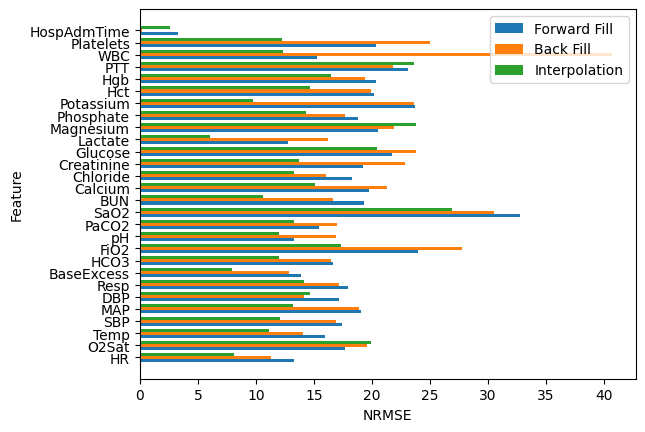

In [22]:
fig, ax = plt.subplots()
x = np.arange(len(ffill_columns))
width = 0.25
ax.barh(x, ffill_measures.mean(axis=0), width, label='Forward Fill')
ax.barh(x + width, bfill_measures.mean(axis=0), width, label='Back Fill')
ax.barh(x + width * 2, interp_measures.mean(axis=0), width, label='Interpolation')
ax.set_yticks(x + width)
ax.set_yticklabels(ffill_columns)
ax.legend(loc='upper right')
ax.set_xlabel('NRMSE')
ax.set_ylabel('Feature')
plt.show()

In [126]:
import random       
def worker(index, r, df):
    imp_mean = IterativeImputer(random_state=r, max_iter=50, missing_values=np.nan, verbose=2, imputation_order='ascending')
    imputed_data = imp_mean.fit_transform(df)
    imputed_df = pd.DataFrame(imputed_data, columns=imp_mean.get_feature_names_out())
    print(imputed_df.head())
    return imputed_df

# impute_data = filtered_data.drop(['Hour', 'Patient_ID'], axis=1)
# miss_df, missing_data = get_imputation_test_df(impute_data, impute_data.columns)
# imputed_data = worker(0, random.randint(0, 2000), miss_df)
# print(imputed_data.head())
# # print('Outputting to csv')
# imputed_data.to_csv('unscaled_imputed_data.csv')
# print('Testing Results')
# test_results = test_imputation(imputed_data, missing_data)
# print(test_results)

In [53]:
def test_imputation_columns(miss_df_imputed, missing_data):
    column_measures = {}
    for c in miss_df_imputed.columns:
        length = 0
        missing_values = []
        for d in missing_data:
            if d[0][1] == c:
                try:
                    column_measures[c] += (d[1] - miss_df_imputed.at[d[0][0],d[0][1]])**2 * 2
                except:
                    column_measures[c] = (d[1] - miss_df_imputed.at[d[0][0],d[0][1]])**2 * 2
                length += 1
                missing_values.append(d[1])
        if c in column_measures.keys():
            column_measures[c] = ((column_measures[c]/length)**0.5)/(max(missing_values)-min(missing_values)) * 100
    return column_measures

In [29]:
impute_early.head()

,Unnamed: 0,Hour,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,Patient_ID
0,0,0,60.0,100.0,37.35,121.5,66.5,43.5,14.0,-1.0,...,21.0,7.1,43.4,0.0,69.0,81.12,1,-42.55,4,19278
1,1,1,112.5,99.0,37.55,108.0,67.0,51.0,12.0,NaN,...,NaN,NaN,NaN,0.0,NaN,81.12,1,-42.55,5,19278
2,2,2,99.0,100.0,37.70,130.5,81.0,63.0,16.0,NaN,...,31.0,10.3,NaN,0.0,NaN,81.12,1,-42.55,6,19278
3,3,3,80.0,100.0,37.70,142.0,81.5,56.5,22.5,NaN,...,NaN,NaN,NaN,0.0,NaN,81.12,1,-42.55,7,19278
4,4,4,80.0,98.0,37.90,155.0,88.0,63.0,29.0,1.0,...,31.0,10.4,NaN,0.0,NaN,81.12,1,-42.55,8,19278


In [22]:
def fill_early_values(input_df):
    df = input_df.copy()
    for c in df.columns:
        if not df[c].isna().all():
            for i in df[c].index:
                if not np.isnan(df[c][i]):
                    value = df[c][i]
                    index = i
                    break
            for i in range(df[c].index[0], index):
                df.at[i, c] = value
    return df
            

In [29]:
impute_data = filtered_data.drop(['Hour', 'SepsisLabel'], axis=1)
group_impute_data = impute_data.groupby('Patient_ID', as_index=False, sort=False)
group_filled_data = group_impute_data.apply(fill_early_values)


In [41]:
group_filled_data = group_filled_data.drop(['level_0', 'level_1'], axis=1)
group_filled_data.head(50)

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Hct,Hgb,PTT,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,Patient_ID
0,60.0,100.0,37.35,121.5,66.5,43.5,14.0,-1.0,27.0,1.0,...,21.0,7.1,43.4,13.9,69.0,81.12,1,-42.55,4,19278
1,112.5,99.0,37.55,108.0,67.0,51.0,12.0,NaN,27.0,0.6,...,NaN,NaN,NaN,13.9,NaN,81.12,1,-42.55,5,19278
2,99.0,100.0,37.70,130.5,81.0,63.0,16.0,NaN,27.0,NaN,...,31.0,10.3,NaN,13.9,NaN,81.12,1,-42.55,6,19278
3,80.0,100.0,37.70,142.0,81.5,56.5,22.5,NaN,27.0,0.5,...,NaN,NaN,NaN,13.9,NaN,81.12,1,-42.55,7,19278
4,80.0,98.0,37.90,155.0,88.0,63.0,29.0,1.0,27.0,0.4,...,31.0,10.4,NaN,13.9,NaN,81.12,1,-42.55,8,19278
5,80.0,99.0,37.80,143.5,83.5,60.0,19.5,NaN,27.0,NaN,...,NaN,NaN,NaN,13.9,NaN,81.12,1,-42.55,9,19278
6,80.0,97.5,37.70,133.5,78.0,56.0,24.0,NaN,27.0,NaN,...,NaN,NaN,NaN,13.9,NaN,81.12,1,-42.55,10,19278
7,80.5,97.5,37.60,119.0,70.5,51.0,17.5,NaN,27.0,NaN,...,NaN,NaN,NaN,13.9,NaN,81.12,1,-42.55,11,19278
8,82.5,98.0,37.50,111.0,66.0,47.5,21.0,NaN,27.0,NaN,...,NaN,NaN,NaN,13.9,NaN,81.12,1,-42.55,12,19278
9,82.0,98.0,37.10,106.0,64.0,46.0,22.0,NaN,27.0,NaN,...,NaN,NaN,NaN,13.9,NaN,81.12,1,-42.55,13,19278


In [42]:
import random       
def worker(index, r, df):
    imp_mean = IterativeImputer(random_state=r, max_iter=50, missing_values=np.nan, verbose=2, imputation_order='ascending')
    imputed_data = imp_mean.fit_transform(df)
    imputed_df = pd.DataFrame(imputed_data, columns=imp_mean.get_feature_names_out())
    print(imputed_df.head())
    return imputed_df

group_impute_data = group_filled_data.groupby('Patient_ID')
group_imputed_data = group_impute_data.apply(lambda x: x.interpolate(method='linear'))
group_imputed_data = group_imputed_data.drop(['Patient_ID'], axis=1)
imputed_data = worker(0, random.randint(0, 2000), group_imputed_data)
imputed_data['Patient_ID'] = impute_data['Patient_ID']
imputed_data['Hour'] = filtered_data['Hour']
imputed_data.head()
# column_test_results = test_imputation_columns(imputed_data, missing_data)
# group_column_test_results = test_imputation_columns(group_imputed_data, missing_data)
# print(column_test_results)
# print(group_column_test_results)


[IterativeImputer] Completing matrix with shape (790215, 31)
[IterativeImputer] Ending imputation round 1/50, elapsed time 74.04
[IterativeImputer] Change: 326.501286450419, scaled tolerance: 3.71066 
[IterativeImputer] Ending imputation round 2/50, elapsed time 151.25
[IterativeImputer] Change: 215.5522897974659, scaled tolerance: 3.71066 
[IterativeImputer] Ending imputation round 3/50, elapsed time 232.89
[IterativeImputer] Change: 59.91320798983796, scaled tolerance: 3.71066 
[IterativeImputer] Ending imputation round 4/50, elapsed time 319.10
[IterativeImputer] Change: 20.16357478401546, scaled tolerance: 3.71066 
[IterativeImputer] Ending imputation round 5/50, elapsed time 403.10
[IterativeImputer] Change: 11.65542207430337, scaled tolerance: 3.71066 
[IterativeImputer] Ending imputation round 6/50, elapsed time 482.17
[IterativeImputer] Change: 7.549781188796169, scaled tolerance: 3.71066 
[IterativeImputer] Ending imputation round 7/50, elapsed time 561.62
[IterativeImputer] C

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Hgb,PTT,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,Patient_ID,Hour
0,60.0,100.0,37.35,121.5,66.5,43.5,14.0,-1.0,27.0,1.00,...,7.10,43.4,13.9,69.0,81.12,1.0,-42.55,4.0,19278,0
1,112.5,99.0,37.55,108.0,67.0,51.0,12.0,-0.5,27.0,0.60,...,8.70,43.4,13.9,71.9,81.12,1.0,-42.55,5.0,19278,1
2,99.0,100.0,37.70,130.5,81.0,63.0,16.0,0.0,27.0,0.55,...,10.30,43.4,13.9,74.8,81.12,1.0,-42.55,6.0,19278,2
3,80.0,100.0,37.70,142.0,81.5,56.5,22.5,0.5,27.0,0.50,...,10.35,43.4,13.9,77.7,81.12,1.0,-42.55,7.0,19278,3
4,80.0,98.0,37.90,155.0,88.0,63.0,29.0,1.0,27.0,0.40,...,10.40,43.4,13.9,80.6,81.12,1.0,-42.55,8.0,19278,4


In [43]:
imputed_data.head(50)

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,HCO3,FiO2,...,Hgb,PTT,WBC,Platelets,Age,Gender,HospAdmTime,ICULOS,Patient_ID,Hour
0,60.0,100.0,37.350000,121.5,66.5,43.5,14.0,-1.00,27.000000,1.00,...,7.100000,43.400000,13.900000,69.000000,81.12,1.0,-42.55,4.0,19278,0
1,112.5,99.0,37.550000,108.0,67.0,51.0,12.0,-0.50,27.000000,0.60,...,8.700000,43.400000,13.900000,71.900000,81.12,1.0,-42.55,5.0,19278,1
2,99.0,100.0,37.700000,130.5,81.0,63.0,16.0,0.00,27.000000,0.55,...,10.300000,43.400000,13.900000,74.800000,81.12,1.0,-42.55,6.0,19278,2
3,80.0,100.0,37.700000,142.0,81.5,56.5,22.5,0.50,27.000000,0.50,...,10.350000,43.400000,13.900000,77.700000,81.12,1.0,-42.55,7.0,19278,3
4,80.0,98.0,37.900000,155.0,88.0,63.0,29.0,1.00,27.000000,0.40,...,10.400000,43.400000,13.900000,80.600000,81.12,1.0,-42.55,8.0,19278,4
5,80.0,99.0,37.800000,143.5,83.5,60.0,19.5,1.00,27.000000,0.40,...,10.266667,43.400000,13.900000,83.500000,81.12,1.0,-42.55,9.0,19278,5
6,80.0,97.5,37.700000,133.5,78.0,56.0,24.0,1.00,27.000000,0.40,...,10.133333,43.400000,13.900000,86.400000,81.12,1.0,-42.55,10.0,19278,6
7,80.5,97.5,37.600000,119.0,70.5,51.0,17.5,1.00,27.000000,0.40,...,10.000000,43.400000,13.900000,89.300000,81.12,1.0,-42.55,11.0,19278,7
8,82.5,98.0,37.500000,111.0,66.0,47.5,21.0,1.00,27.000000,0.40,...,9.866667,43.400000,13.900000,92.200000,81.12,1.0,-42.55,12.0,19278,8
9,82.0,98.0,37.100000,106.0,64.0,46.0,22.0,1.00,27.000000,0.40,...,9.733333,43.400000,13.900000,95.100000,81.12,1.0,-42.55,13.0,19278,9


In [40]:
imputed_data['SepsisLabel'] = filtered_data['SepsisLabel']
imputed_data.to_csv('filled_first_imputed_data.csv')

In [124]:
column_test_results_2 = column_test_results

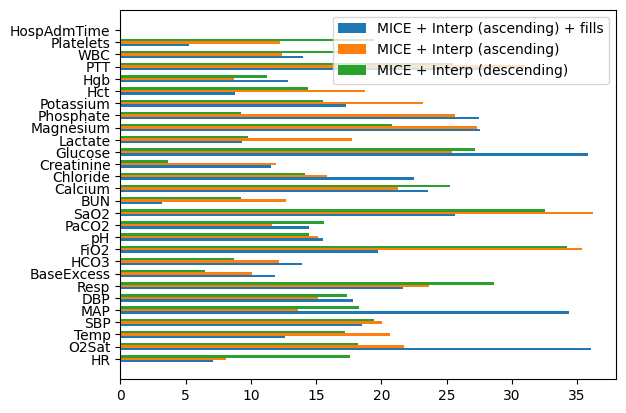

In [129]:
fig, ax = plt.subplots()
x = np.arange(len(ffill_columns))
width = 0.2
ax.barh(x, column_test_results.values(), width, label='MICE + Interp (ascending) + fills')
ax.barh(x + width, column_test_results_1.values(), width, label='MICE + Interp (ascending)')
ax.barh(x + width * 2, column_test_results_2.values(), width, label='MICE + Interp (descending)')
ax.set_yticks(x + width)
ax.set_yticklabels(ffill_columns)
ax.legend(loc='upper right')
plt.show()